In [17]:
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models import densenet121, resnet101

In [18]:
classes = [
    'No Finding',
    'Enlarged Cardiomediastinum',
    'Cardiomegaly', 
    'Lung Opacity',
    'Lung Lesion',
    'Edema',
    'Consolidation', 
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices'
]

In [19]:
def plot_auc_and_test_model(model, test_loader, model_name, classes):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = torch.sigmoid(model(inputs))
            
            y_true.append(labels.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
    
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    fpr = {}
    tpr = {}
    roc_auc = {}
    youdens_index = {}

    # Iterate over each label and compute the ROC curve, AUROC, and Youden's Index
    for i, class_ in enumerate(classes):
        fpr[class_], tpr[class_], thresholds = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[class_] = auc(fpr[class_], tpr[class_])
        
        # Compute Youden's Index for each threshold
        youdens = tpr[class_] - fpr[class_]
        optimal_idx = np.argmax(youdens)  # Index of the maximum Youden's Index
        youdens_index[class_] = {
            'index': youdens[optimal_idx],
            'threshold': thresholds[optimal_idx],
            'fpr': fpr[class_][optimal_idx],
            'tpr': tpr[class_][optimal_idx]
        }

    # Plot the ROC curve for each label
    plt.figure(figsize=(10, 8))
    for class_ in classes:
        plt.plot(fpr[class_], tpr[class_], label=f'{class_} (AUROC = {roc_auc[class_]:.2f})')
    
    # Plot the diagonal (random guess line)
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess (AUROC = 0.5)')
    
    # Add labels and legend
    plt.title(f'Multi-label (ROC) Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    return pd.DataFrame(youdens_index).T.to_csv(f'{model_name}.csv')

In [20]:
test_u0 = pd.read_csv('/kaggle/input/chexpertclean/u0_test.csv', index_col=0)
test_u1 = pd.read_csv('/kaggle/input/chexpertclean/u1_test.csv', index_col=0)
test_u0.index = test_u0.index.str.replace('CheXpert-v1.0-small', 'chexpert')
test_u1.index = test_u1.index.str.replace('CheXpert-v1.0-small', 'chexpert')

In [21]:
class CheXpertDataset(Dataset):
    '''
    Custom dataset for CheXpert. Returns a tuple of (PIL.Image, torch.Tensor (float32)).
    Args:
        data (pd.Dataframe): dataset with image path as indexes and columns as labels, all values are 0 (negative) or 1 (postivive)
        root_dir (str): root directory of dataset folder
        mode ('train', 'val'): mode for different augmentation
        transforms (albumentations): augmentation techniques to use
    '''
    def __init__(self, data, root_dir, mode='train', transforms=None):
        self.data = data.to_numpy()
        self.labels = torch.tensor(data.values.astype(np.float32))
        self.root_dir = root_dir
        self.img_paths = [os.path.join(root_dir, img_path) for img_path in data.index]
        self.transform = transforms.get(mode)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=np.array(image))['image']

        return (image, label)
    
'''
Augmentations:
    - Scale 5% with p = 50%
    - Rotate 20° OR shear 5 pixels with p = 50%
    - Translate 5% with p = 50%
    - Resize to 224x224
    - Normalize with mean = 0.506 and std = 0.287, more details in data_preprocessing.ipynb
    - Convert to torch.Tensor
'''
transform = {
    'train': A.Compose([
        A.Affine(scale=(0.95, 1.05), p=0.5),
        A.OneOf([A.Affine(rotate=(-20, 20), p=0.5), A.Affine(shear=(-5, 5), p=0.5)], p=0.5),
        A.Affine(translate_percent=(-0.05, 0.05), p=0.5),
        A.Resize(224, 224),
        A.Normalize([0.506, 0.506, 0.506], [0.287, 0.287, 0.287]),
        ToTensorV2()
    ]),
    'val': A.Compose([
        A.Resize(224, 224),
        A.Normalize([0.506, 0.506, 0.506], [0.287, 0.287, 0.287]),
        ToTensorV2()
    ]),
}

In [22]:
batch_size = 32

test_dataset = CheXpertDataset(
    test_u0, '/kaggle/input/', #u1
    mode='val',
    transforms = transform)

test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    num_workers = 4,
    pin_memory=True)

In [23]:
model = resnet101(num_classes=14)
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=14)
model.load_state_dict(torch.load('/kaggle/input/resnettl/pytorch/resnet_tl_u1/1/ResNetTL-U0.pth', weights_only=True))

<All keys matched successfully>

Testing: 100%|██████████| 587/587 [00:48<00:00, 12.13batch/s]


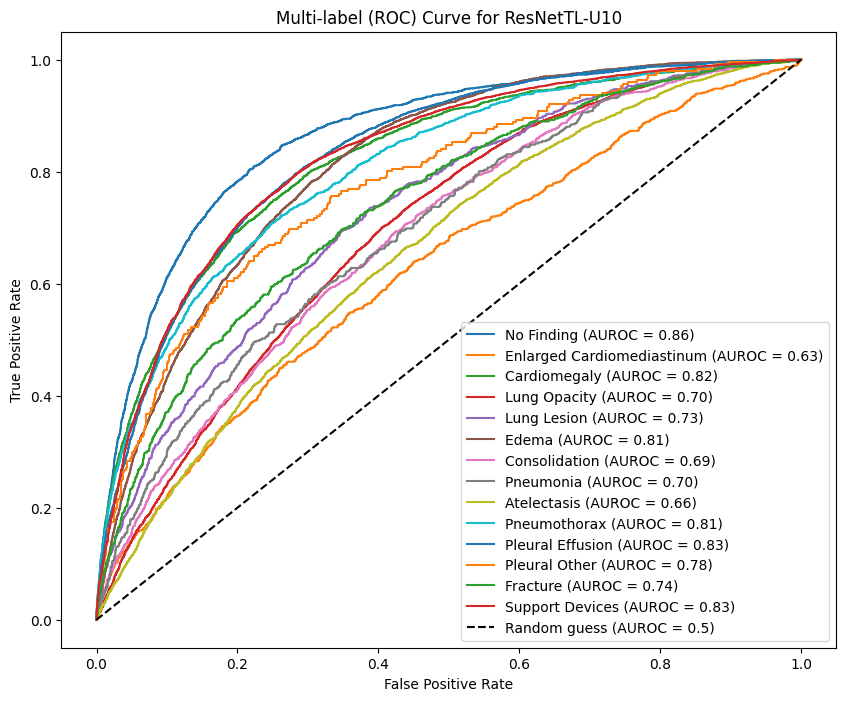

In [24]:
plot_auc_and_test_model(model, test_loader, model_name = 'ResNetTL-U10', classes=classes)